# グラフサンプルの作成手順
----
本章ではElasticsearchへ登録したデータを可視化するサンプルとして、3つの例を紹介します。
1. ネットワークトラフィックの流量の可視化
1. ネットワークトラフィックのPORTの分類
1. ネットワークトラフィックの地理情報の可視化


各サーバにAnsibleコマンドを発行するため、  
Ansibleを実行可能なユーザアカウントとそのSSHキーを次のセルで設定してください。

In [1]:
USER='ansible'
KEYPATH = '/notebooks/work/ansible_id_rsa'

この後のコマンドを実行するために、Client Nodeのアドレスか、それが無い場合はData Nodeのうちの1つのアドレスを設定してください。 

In [2]:
%env ES_CLIENT=192.168.122.80:9200

env: ES_CLIENT=192.168.122.80:9200


このNotebookを含むファイルを設置したディレクトリを読み込みます。  
※Logstash用の設定ファイルやサンプルデータはこの配下から取得します。変更する場合は下の設定を書き換えてください。

In [3]:
import os
notebooks_home = os.getcwd()
notebooks_home

'/notebooks/work/Literate-computing-Elasticsearch'

## ネットワークの流量監視グラフ
ネットワークの流量を折れ線グラフで可視化します。  
グラフは下記手順で作成します。
1. 可視化対象のログファイル(以降、トラフィックログファイル)を入力ファイルに設定してlogstashを起動。
1. 定期的にトラフィックログファイルへトラフィックログを出力するスクリプト(以降、疑似ログ出力スクリプト)を起動。
1. Elasticsearchへ登録されたトラフィックログに対し定期的に検索を実施。
1. 検索結果を集約し、グラフ化する。　

※本グラフ作成にあたって、書き込みのリアルタイム性を表現するため、実際の運用上では不要な疑似ログ出力スクリプト実行の手順が含まれています。  
該当する手順については「※次のセルはデモ用の操作です。本Notebookのデモ以外では実行不要です。」と記載しています。

### 環境設定ファイルの設置
Logstash用の環境設定ファイルをサーバにコピーします。

サンプルデータをElasticsearchに登録するための設定は、[logstash_conf/main_networktraffic.conf](logstash_conf/main_networktraffic.conf)を用います。  
LogstashサーバがData Nodeと同じホストに無い場合は、  
main.confの "**hosts => ～～**" の部分にClient Nodeか、それが無い場合はData Nodeのリストを定義してください。  
複数の場合は  
["127.0.0.1:9200","127.0.0.2:9200"]  
のようにします。

次のリンクから修正してください。

- **[main_networktraffic.conf](../edit/logstash_conf/main_networktraffic.conf)**

ここで利用するmain_networktraffic.confはファイルから読み込んだCSV形式の内容をElasticsearchに格納するための設定です。  
具体的な意味は[04_Store_Data](04_Store_Data.ipynb)を参照してください。

main_networktraffic.confを /etc/logstash/conf.d/ 配下にコピーします。

In [6]:
!ansible-playbook playbooks/copy_main_networktraffic_conf.yml --extra-vars "notebooks_home=$notebooks_home user=$USER" -i ./hosts -u $USER --private-key=$KEYPATH


PLAY [logstash-server] *********************************************************

TASK [Gathering Facts] *********************************************************
ok: [192.168.122.80]

TASK [copy local main.conf to remote] ******************************************
ok: [192.168.122.80]

TASK [set input file directory] ************************************************
ok: [192.168.122.80]

PLAY RECAP *********************************************************************
192.168.122.80             : ok=3    changed=0    unreachable=0    failed=0   



### データ型の定義（マッピング定義）
サンプルデータ用のCSVの各列について、データ型をあらかじめ定義しておきます。

データ型の種類およびマッピング定義の詳細に関しては[05_Indexing](05_Indexing.ipynb)を参照してください。  
次のコマンドを実行してマッピング定義を行います。  

In [81]:
%%bash
curl -XPUT "http://$ES_CLIENT/_template/traffic" -H 'Content-Type:application/json' -d @- << EOF
{
    "index_patterns": "networktraffic-*",
    "mappings": {
        "logs": {
            "properties": {
                "src_ip": {
                    "type": "ip"
                },
                "src_port": {
                    "type": "integer"
                },
                "dst_ip": {
                    "type": "ip"
                },
                "dst_port": {
                    "type": "integer"
                },
                "src_ip-dst_ip": {
                    "type": "keyword"
                },
                "protocol": {
                    "type": "text"
                },
                "ssl": {
                    "type": "text"
                },
                "rate": {
                    "type": "integer"
                }
            }
        }
    }
}
EOF

{"acknowledged":true}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   799  100    21  100   778   1653  61274 --:--:-- --:--:-- --:--:-- 64833


### サンプルデータの投入
実際のサンプルデータをLogstashに投入します。

ここではネットワークセキュリティのコンペティションで使用されたトラフィックデータを利用します。
[SecRepo.com「conn.log」](http://www.secrepo.com/)

公開されているトラフィックデータの一部を、シェルスクリプト(疑似ログ出力スクリプト)で加工して定期的にトラフィックログファイルに出力します。  
トラフィックログファイルへのログ出力をlogstashが読み取り、Elasticsearchにログが登録される様設定します。  
トラフィックデータの内、使用する項目は、次のように対応しています。

| サンプルデータの項目 | トラフィックデータの項目 | 備考 |
|-----------|--------------------|------|
| @timestamp | 年月日 ||
| src_ip | 通信元IP ||
| src_port | 通信元ポート ||
| dst_ip | 通信先IP ||
| dst_port | 通信先ポート ||
| protocol | 通信プロトコル ||
| ssl | ssl通信かどうか |"http"もしくは"https"|
| rate | 通信量 |単位：KB||

トラフィックデータの利用あたってはSecRepo.comが公開している[Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/)を参照してください。

登録するデータの内容は次のコマンドで確認できます。  
Elasticsearchは慣習として時刻情報を@timestampというフィールドに格納します。

In [7]:
!head -n 5 ./sample_data/networktraffic.csv

1331901000.000000,CCUIP21wTjqkj8ZqX5,192.168.202.79,50463,192.168.229.251,80,tcp,-,-,-,-,SH,-,0,Fa,1,52,1,52,(empty)
1331901000.000000,Csssjd3tX0yOTPDpng,192.168.202.79,46117,192.168.229.254,443,tcp,-,-,-,-,SF,-,0,dDafFr,3,382,9,994,(empty)
1331901000.000000,CHEt7z3AzG4gyCNgci,192.168.202.79,50465,192.168.229.251,80,tcp,http,0.010000,166,214,SF,-,0,ShADfFa,4,382,3,382,(empty)
1331901000.010000,CKnDAp2ohlvN6rpiXl,192.168.202.79,50467,192.168.229.251,80,tcp,http,0.010000,166,214,SF,-,0,ShADfFa,4,382,3,382,(empty)
1331901000.000000,CGUBcoXKxBE8gTNl,192.168.202.79,46119,192.168.229.254,443,tcp,ssl,0.020000,544,1060,SF,-,0,ShADadfFr,8,968,13,1744,(empty)


Logstashのサーバーにサンプルデータをコピーします。   
Logstashをインストールしたサーバーの ~/ 配下に[sample_data](sample_data)のnetworktraffic.csvをコピーします。

In [8]:
!ansible-playbook playbooks/copy_networktraffic_csv.yml --extra-vars "notebooks_home=$notebooks_home" -i ./hosts -u $USER --private-key=$KEYPATH


PLAY [logstash-server] *********************************************************

TASK [Gathering Facts] *********************************************************
ok: [192.168.122.80]

TASK [copy local networktraffic.csv to remote] *********************************
ok: [192.168.122.80]

PLAY RECAP *********************************************************************
192.168.122.80             : ok=2    changed=0    unreachable=0    failed=0   



※次のセルはデモ用の操作です。本Notebookのデモ以外では実行不要です。  

Logstashのサーバーに、疑似ログ出力スクリプトをコピーします。

In [9]:
!ansible-playbook playbooks/copy_output_shell.yml --extra-vars "notebooks_home=$notebooks_home" -i ./hosts -u $USER --private-key=$KEYPATH


PLAY [logstash-server] *********************************************************

TASK [Gathering Facts] *********************************************************
ok: [192.168.122.80]

TASK [copy local sample data to remote] ****************************************
ok: [192.168.122.80]

PLAY RECAP *********************************************************************
192.168.122.80             : ok=2    changed=0    unreachable=0    failed=0   



トラフィックログファイルを入力に設定したLogstashを起動します。  
ログファイルにログが追加されると、Elasticsearchへログが登録されます。次のセルのコマンドを実行してください。

In [10]:
!ansible logstash-server -i ./hosts -m shell -a ">~/traffic_log" -u $USER --private-key=$KEYPATH
!ansible logstash-server -i ./hosts -m shell -a "nohup sudo /usr/share/logstash/bin/logstash -f /etc/logstash/conf.d/main_networktraffic.conf >logstash.log 2>&1 &" -u $USER --private-key=$KEYPATH

192.168.122.80 | SUCCESS | rc=0 >>


192.168.122.80 | SUCCESS | rc=0 >>




データ登録のためのlogstashが起動しているかどうかは、次のセルを実行することで確認できます。

In [11]:
!ansible logstash-server -i ./hosts -m shell -a "sudo ps -aux | grep logstash | grep -v 'grep' | grep sudo" -u $USER --private-key=$KEYPATH

 [WARNING]: Consider using 'become', 'become_method', and 'become_user' rather
than running sudo

192.168.122.80 | SUCCESS | rc=0 >>
root     20639  0.0  0.1 197640  2880 ?        S    13:18   0:00 sudo /usr/share/logstash/bin/logstash -f /etc/logstash/conf.d/main_networktraffic.conf



※次のセルのコマンドはデモ用です。本Notebookのデモ以外では実行不要です。  

疑似ログ出力スクリプトを実行し、トラフィックログファイルへトラフィックログを定期的に出力します。

In [12]:
!ansible logstash-server -i ./hosts -m shell -a "nohup sudo sh ~/output_traffic_files.sh ~/networktraffic.csv ~/traffic_log &" -u $USER --private-key=$KEYPATH

192.168.122.80 | SUCCESS | rc=0 >>




Elasticsearchへデータが登録されているか、確認します。次のセルのコマンドを実行してください。<br>
※データ登録までは少し時間がかかります。<br>
検索結果が0件だった場合は数分後にもう一回実行し、検索結果が取得できることを確認してください。

In [13]:
!curl -XGET http://$ES_CLIENT/networktraffic-*/_search?pretty

{
  "took" : 18,
  "timed_out" : false,
  "_shards" : {
    "total" : 1,
    "successful" : 1,
    "skipped" : 0,
    "failed" : 0
  },
  "hits" : {
    "total" : 1000445,
    "max_score" : 1.0,
    "hits" : [
      {
        "_index" : "networktraffic-2018.04",
        "_type" : "logs",
        "_id" : "dBb3k2IB8cgw6GYcU3lQ",
        "_score" : 1.0,
        "_source" : {
          "src_ip" : "192.168.202.76",
          "host" : "es01",
          "message" : "1522900865,1331901000.330000,CA4V0d4Mt2NKAU1n0l,192.168.202.76,51658,157.56.52.15,40046,tcp,-,3.080000,0,0,S0,-,0,S,2,104,0,0,(empty)",
          "dst_ip" : "157.56.52.15",
          "protocol1" : "tcp",
          "path" : "/home/ansible/traffic_log",
          "@timestamp" : "2018-04-05T04:01:05.000Z",
          "src_ip-dst_ip" : "192.168.202.76-157.56.52.15",
          "rate" : "104",
          "@version" : "1",
          "src_port" : "51658",
          "ssl" : "-",
          "dst_port" : "40046"
        }
      },
      {
     

登録したデータの内容がJSON形式で表示されるので、それを確認してください。  
レスポンスのサイズを指定していないため、ここでは最大10件まで確認できます。

### 集約機能について

Elasticsearchに登録されたデータに対し、集約を指定してクエリを発行することで、集約・集計された情報を検索する事ができます。  
集約・集計については[03_Aggregation.ipynb](03_Aggregation.ipynb)を参照してください。

今回は流量を計測するサンプルの為に、クエリを記載した「aggregate_traffic.json」ファイルを使い、ログ情報から時間ごとの流量を集約します。  
以下のコマンドでaggregate_traffic.jsonファイルを参照します。

In [1]:
!cat ./sample_data/aggregate_traffic.json

{
  "size": 0,
  "aggs": {
    "by_time_range": {
      "filter": {
        "range": {
          "@timestamp": {
            "gte": "now-1m",
            "lte": "now"
          }
        }
      },
      "aggs": {
        "by_src_dst_ip": {
          "terms": {
            "field": "src_ip-dst_ip"
          },
          "aggs": {
            "by_time": {
              "date_histogram": {
                "field": "@timestamp",
                "interval":"1s"
              },
              "aggs": {
                "sum_rate": {
                  "sum": {
                    "field": "rate"
                  }
                }
              }
            }
          }
        }
      }
    }
  }
}

上記クエリでは以下の通りに集約を行います。
1. filter Aggregation「by_time_range」で、@timestampフィールドが1分前から現在までのデータに絞ります。
1. terms Aggregation「by_src_dst_ip」で、src_ip-dst_ipフィールド(通信元/先IPのセット)ごとに分類します。
1. date_histogram Aggregation「by_time」で、@timestampフィールドが1秒ごとの単位になる様データを集約します。
1. sum Aggregation「sum_rate」で、1～3で分類した対象に対しrateフィールド(流量)の合計値をそれぞれ集計します。


上記クエリの構造を変更したい場合は、次のリンクから修正してください。
例えば、1分前からではなく10分前から現在のデータに絞りたい場合、filter Aggregation「by_time_range」の"now-1m"設定を"now-10m"に変更します。

- **[aggregate_traffic.json](../edit/logstash_conf/aggregate_traffic.json)**

### グラフの表示
Elasticsearchに登録されたデータを、グラフで可視化します。  

※参考のため、下記コードを事前に実行した結果をピン留めしています。

KeyboardInterrupt: 

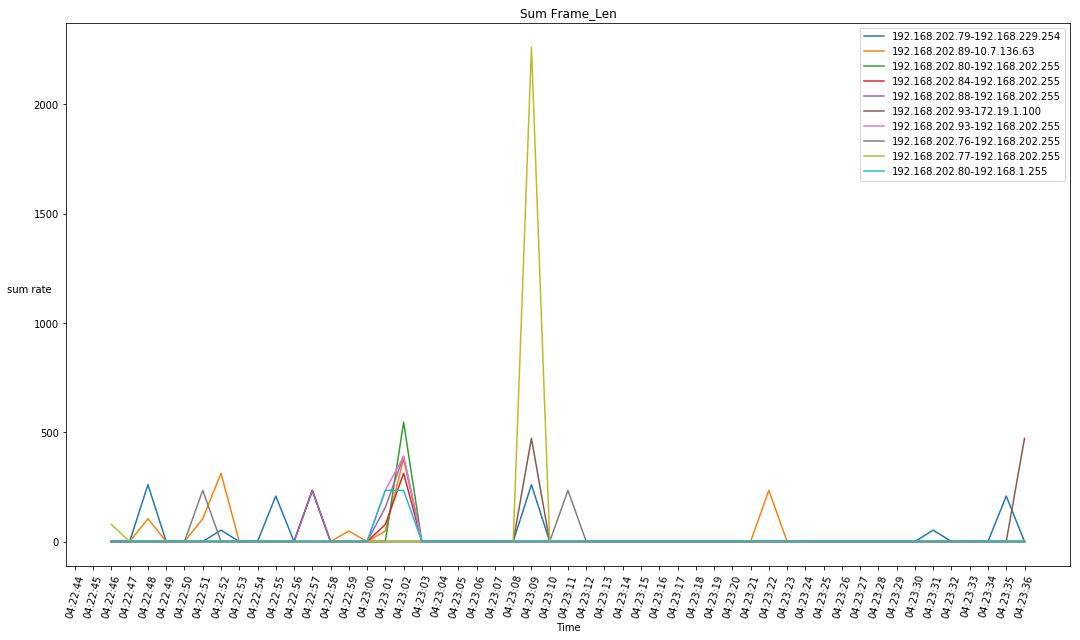

In [15]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from pylab import rcParams
from time import sleep
from datetime import datetime, timedelta

# グラフ表示更新間隔
INTERVAL = 1
# グラフ表示更新回数
LOOP_COUNT=60

def result_to_df(result):
    """
    Elasticsearchからの検索結果をDataFrameフォーマットに変換する。
    """
    base_df = pd.DataFrame()
    for src_dst in result:
        time_buckets = src_dst['by_time']['buckets']
        rate_time_mat = {}
        for time_bucket in time_buckets:
            epoch_time = time_bucket['key'] / 1000
            event_time = datetime.fromtimestamp(epoch_time).strftime("%H:%M:%S")
            rate_time_mat.update({event_time: time_bucket['sum_rate']['value']})

        src_dst_df = pd.DataFrame(rate_time_mat, index=[src_dst.get('key', 0)])

        base_df = pd.concat([base_df, src_dst_df])
    return base_df


def get_es_data():
    """
    Elasticsearchへ検索リクエストを送信し、結果を返却する。
    """
    result = !curl -XGET http://$ES_CLIENT/networktraffic-*/_search -H 'Content-Type:application/json' -d @./sample_data/aggregate_traffic.json 2>/dev/null
    if len(result) == 0:
        return pd.DataFrame()
    result = json.loads(result[0])["aggregations"]["by_time_range"]

    src_dst_ip = result["by_src_dst_ip"]["buckets"]
    base_df = result_to_df(src_dst_ip)

    base_df = base_df.fillna(0)
    return base_df


def plot(fig, ax):
    """
    検索結果DataFrameをグラフへプロットする。
    """
    base_df = get_es_data()
    count = 0
    clear_output(wait=True)
    while count < len(base_df.index):
        src_dst_line = base_df.iloc[count]
        ax.plot(src_dst_line)
        count += 1
    plt.title("Sum Frame_Len")
    plt.legend(loc='upper right')
    plt.xlabel("Time")
    plt.ylabel("sum rate", rotation=0)
    plt.xticks(rotation=75)


rcParams['figure.figsize'] = 18, 10
fig, ax = plt.subplots()

# 指定した回数、更新間隔でグラフを表示する。
for index in range(LOOP_COUNT):
    plot(fig, ax)
    display(fig)
    sleep(INTERVAL)

    if index != LOOP_COUNT - 1:
        ax.cla()
    else:
        clear_output(wait=True)

ネットワーク全体の流量(KB)から、特に通信の多いもの(送信元IP-送信先IP)が分かります。  
これにより例えば、特定のサーバから攻撃を受けている、などの様子が分かります。

### データ定期投入プロセスの削除

※次のセルはデモ用の操作です。本Notebookのデモ以外では実行不要です。

データを定期投入している疑似ログ出力スクリプトを停止します。次のセルのコマンドを実行してください。

In [16]:
!ansible logstash-server -i ./hosts -m shell -a "sudo ps -aux | grep 'output_traffic_files.sh' | grep -v 'grep' | sed -e 's/^[^ ]*[ ]*\([^ ]*\) .*/\1/' |xargs --no-run-if-empty sudo kill -9" -u $USER --private-key=$KEYPATH

 [WARNING]: Consider using 'become', 'become_method', and 'become_user' rather
than running sudo

192.168.122.80 | SUCCESS | rc=0 >>




ログ入力を待ち受けているlogstashプロセスを終了します。次のセルのコマンドを実行してください。  
「1.1.3 サンプルデータの投入」を実行した場合は、必ず実行してプロセスを終了してください。

In [17]:
!ansible logstash-server -i ./hosts -m shell -a "sudo ps -aux | grep '/etc/logstash/conf.d/main_networktraffic.conf' | grep -v 'grep' | sed -e 's/^[^ ]*[ ]*\([^ ]*\) .*/\1/' |xargs --no-run-if-empty sudo kill -9" -u $USER --private-key=$KEYPATH

 [WARNING]: Consider using 'become', 'become_method', and 'become_user' rather
than running sudo

192.168.122.80 | SUCCESS | rc=0 >>




## ポート別アクセス数及び流量可視化グラフ  

「1.1 ネットワークの流量監視グラフ」で用いたデータを利用し、ポート別のアクセス数および流量を円グラフによって可視化します。

Elasticsearchにデータが登録されているか、以下のコマンドで確認します。  
hitsのtotalが0(データが0件)の場合は、1.1.1～1.1.6を実施してください。

In [67]:
!curl -XGET http://$ES_CLIENT/networktraffic-*/_search?pretty

{
  "took" : 5,
  "timed_out" : false,
  "_shards" : {
    "total" : 1,
    "successful" : 1,
    "skipped" : 0,
    "failed" : 0
  },
  "hits" : {
    "total" : 341905,
    "max_score" : 1.0,
    "hits" : [
      {
        "_index" : "networktraffic-2018.04",
        "_type" : "logs",
        "_id" : "HQLAj2IB8cgw6GYcPwDv",
        "_score" : 1.0,
        "_source" : {
          "src_port" : "50679",
          "ssl" : "http",
          "path" : "/home/ansible/traffic_log",
          "dst_port" : "80",
          "@version" : "1",
          "protocol1" : "tcp",
          "rate" : "375",
          "message" : "1522830154,1331901001.420000,CUPC5u1vpLgZ8PdH1d,192.168.202.79,50679,192.168.229.251,80,tcp,http,0.020000,159,214,SF,-,0,ShADfFa,4,375,3,382,(empty)",
          "@timestamp" : "2018-04-04T08:22:34.000Z",
          "host" : "es01",
          "src_ip-dst_ip" : "192.168.202.79-192.168.229.251",
          "src_ip" : "192.168.202.79",
          "dst_ip" : "192.168.229.251"
        }
   

### 集約機能について

今回のサンプルでは、「1.1 ネットワークの流量監視グラフ」において実施した際とは異なる集約構造で  
データを集約、グラフを作成するため、以下のファイルを利用します。

* ファイル1:「aggregate_port_count.json」 
* ファイル2:「aggregate_port_rate.json」
* ファイルパス:「./sample_data/aggregate_port.json」
* ファイルパス:「./sample_data/aggregate_port_rate.json」

以下のコマンドでそれぞれのファイルを参照します。

In [11]:
!cat ./sample_data/aggregate_port_count.json

{
    "size": 0,
    "aggs": {
        "by_dst_port": {
            "terms": {
                "field": "dst_port",
                "order": {
                    "_count": "desc"
                }
            }
        }
    }
}

【上記クエリの説明】　
1. terms Aggregation「by_dst_port」によりフィールド「dst_port」ごとのドキュメント数を集約します。
1. 「"order":{"_count":"desc"}」により、集約したドキュメント数を降順に並べます。

In [12]:
!cat ./sample_data/aggregate_port_rate.json

{
    "size": 0,
    "aggs": {
        "by_dst_port": {
            "terms": {
                "field": "dst_port",
                "order": {
                    "sum_rate": "desc"
                }
            },
            "aggs": {
                "sum_rate": {
                    "sum": {
                        "field": "rate"
                    }
                }
            }
        }
    }
}

【上記クエリの説明】　
- terms Aggregation「by_dst_port」により、フィールド「dst_port」におけるドキュメントの値を集約します。　
- 「"order":{"sum_rate":"desc"}」により、「sum_rate」の集約結果が降順に並べられます。　
- terms Aggregation「sum_rate」により、フィールド「rate」のドキュメントの値を合計します。

### グラフの表示

次のセルを実行することで、データをグラフ化します。  

※参考のため、下記コードを事前に実行した結果をピン留めしています。

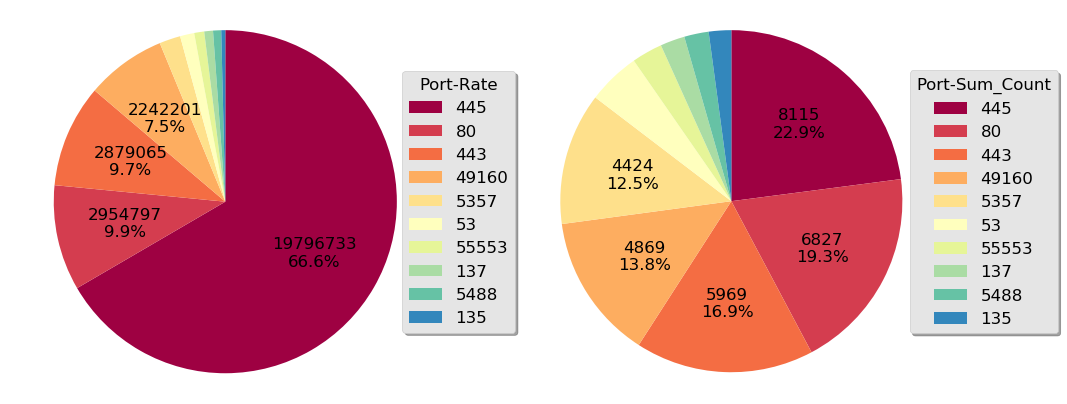

In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def params_list(result):
    """
    Elasticsearchからの検索結果をリストに変換する。
    """
    labels = []
    values = []

    for column in result:
        port = column.get("key", {})
        labels.append(port)
        if "sum_rate" in column:
            rate = column["sum_rate"]["value"]
            values.append(rate)
        else:
            count = column.get("doc_count", {})
            values.append(count)

    return (values, labels)

result_port_count = !curl -XGET http://$ES_CLIENT/networktraffic-*/_search -H 'Content-Type:application/json' -d @./sample_data/aggregate_port_count.json 2>/dev/null
result_port_count = json.loads(result_port_count[0]).get("aggregations",{}).get("by_dst_port",{}).get("buckets",{})

result_port_rate = !curl -XGET http://$ES_CLIENT/networktraffic-*/_search -H 'Content-Type:application/json' -d @./sample_data/aggregate_port_rate.json 2>/dev/null
result_port_rate = json.loads(result_port_rate[0]).get("aggregations",{}).get("by_dst_port",{}).get("buckets",{})

data_count, label = params_list(result_port_count)
data_rate, label = params_list(result_port_rate)

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

size = (12, 5)
col1 = cm.Spectral(np.arange(len(data_rate)) / float((len(data_rate))))
col2 = cm.Spectral(np.arange(len(data_count)) / float((len(data_count))))

fig = plt.figure(figsize=size, dpi=100)

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

def make_autopct(values):
    """
    グラフ内のデータ表記を加工し、返却する。
    """
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}\n{p:.1f}%'.format(p=pct,v=val) if pct >= 5 else ''
    return my_autopct

ax1.pie(data_rate, colors=col1, counterclock=False, startangle=90,
        autopct=make_autopct(data_rate))
ax1.legend(label, fancybox=True, shadow=True, loc='center left', bbox_to_anchor=(0.9, 0.5), title="Port-Rate")
ax1.axis("equal")

ax2.pie(data_count, colors=col2, counterclock=False, startangle=90,
        autopct=make_autopct(data_count))
ax2.legend(label, fancybox=True, shadow=True, loc='center left', bbox_to_anchor=(0.9, 0.5), title="Port-Sum_Count")
ax2.axis("equal")
plt.show()


左側の円グラフでネットワーク全体の流量(KB)における、ポート別の流量(KB)が分かります。  
右側の円グラフでネットワーク全体の流量における、ポート別のアクセス回数が分かります。  
これにより、何のプロトコルによる通信が特に通信量が多いのかがわかります。

## 地域別流量可視化地図
ネットワークの通信を通信元/通信先マーカーで表現することにより地図上に可視化します。  
地図は下記手順で作成します。  
1. 可視化対象のログファイル(以降、トラフィックログファイル)を入力ファイルに設定してlogstashを起動。  
  ※ログ読み込み時にgeofilterプラグインを使用し、IPアドレスを緯度経度情報へ変換。
1. 定期的にトラフィックログファイルへトラフィックログを出力するスクリプト(以降、疑似ログ出力スクリプト)を起動。
1. Elasticsearchへ登録されたトラフィックログに対し定期的に検索を実施。
1. 検索結果を集約し、通信元地点、通信先地点を地図上にプロットすることで地域間の通信を可視化。

※本グラフ作成にあたって、書き込みのリアルタイム性を表現するため、実際の運用上では不要な疑似ログ出力スクリプトを実行する手順が含まれています。  
該当する手順については「※次のセルはデモ用の操作です。本Notebookのデモ以外では実行不要です。」と記載しています。

### 環境設定ファイルの設置
Logstash用の環境設定ファイルをサーバにコピーします。

解析対象のトラフィックデータをElasticsearchに登録するための設定は、[logstash_conf/main_networklocation.conf](logstash_conf/main_networklocation.conf)を用います。  
LogstashサーバがData Nodeと同じホストに無い場合は、  
main.confの "**hosts => ～～**" の部分にClient Nodeか、それが無い場合はData Nodeのリストを定義してください。  
複数の場合は  
["127.0.0.1:9200","127.0.0.2:9200"]  
のようにします。

次のリンクから修正してください。

- **[main_networklocation.conf](../edit/logstash_conf/main_networklocation.conf)**

ここで利用するmain_networklocation.confはファイルから読み込んだCSV形式の内容をElasticsearchに格納するための設定です。  
具体的な意味は[04_Store_Data](04_Store_Data.ipynb)を参照してください。

main_networklocation.confを /etc/logstash/conf.d/ 配下にコピーします。

In [43]:
!ansible-playbook playbooks/copy_main_networklocation_conf.yml --extra-vars "notebooks_home=$notebooks_home user=$USER" -i ./hosts -u $USER --private-key=$KEYPATH


PLAY [logstash-server] *********************************************************

TASK [Gathering Facts] *********************************************************
ok: [192.168.122.80]

TASK [copy local main_networklocation.conf to remote] **************************
changed: [192.168.122.80]

TASK [set input file directory] ************************************************
ok: [192.168.122.80]

PLAY RECAP *********************************************************************
192.168.122.80             : ok=3    changed=1    unreachable=0    failed=0   



### データ型の定義（マッピング定義）
トラフィックデータ用のCSVの各列について、データ型をあらかじめ定義しておきます。

In [19]:
%%bash
curl -XPUT "http://$ES_CLIENT/_template/networklocation" -H 'Content-Type:application/json' -d @- << EOF
{
    "index_patterns": "networklocation-*",
    "mappings": {
        "logs": {
            "properties": {
                "src_ip": {
                    "type": "ip"
                },
                "src_port": {
                    "type": "integer"
                },
                "src_latitude": {
                    "type": "float"
                },
                "src_longitude": {
                    "type": "float"
                },
                "dst_ip": {
                    "type": "ip"
                },
                "dst_port": {
                    "type": "integer"
                },
                "dst_latitude": {
                    "type": "float"
                },
                "dst_longitude": {
                    "type": "float"
                },
                "protocol": {
                    "type": "keyword"
                },
                "rate": {
                    "type": "integer"
                }
            }
        }
    }
}
EOF

{"acknowledged":true}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   984  100    21  100   963    379  17384 --:--:-- --:--:-- --:--:-- 17509


### サンプルデータの投入
実際のトラフィックデータをLogstashに投入します。

Logstashのサーバーにトラフィックデータをコピーします。   
Logstashをインストールしたサーバーの ~/ 配下に[sample_data](sample_data)のnetworklocation.csvをコピーします。

In [46]:
!ansible-playbook playbooks/copy_networklocation_csv.yml --extra-vars "notebooks_home=$notebooks_home" -i ./hosts -u $USER --private-key=$KEYPATH


PLAY [logstash-server] *********************************************************

TASK [Gathering Facts] *********************************************************
ok: [192.168.122.80]

TASK [copy local networklocation.csv to remote] ********************************
ok: [192.168.122.80]

PLAY RECAP *********************************************************************
192.168.122.80             : ok=2    changed=0    unreachable=0    failed=0   



※次のセルはデモ用の操作です。本Notebookのデモ以外では実行不要です。

Logstashのサーバーに、定期的にネットワークログを出力する疑似ログ出力スクリプトをコピーします。

In [25]:
!ansible-playbook playbooks/copy_output_location_shell.yml --extra-vars "notebooks_home=$notebooks_home" -i ./hosts -u $USER --private-key=$KEYPATH


PLAY [logstash-server] *********************************************************

TASK [Gathering Facts] *********************************************************
ok: [192.168.122.80]

TASK [copy local sample data to remote] ****************************************
ok: [192.168.122.80]

PLAY RECAP *********************************************************************
192.168.122.80             : ok=2    changed=0    unreachable=0    failed=0   



トラフィックログファイルを入力に設定したLogstashを起動します。  
ログファイルにログが追加されると、Elasticsearchへログが登録されます。次のセルのコマンドを実行してください。

In [40]:
!ansible logstash-server -i ./hosts -m shell -a ">~/traffic_location_log" -u $USER --private-key=$KEYPATH
!ansible logstash-server -i ./hosts -m shell -a "nohup sudo /usr/share/logstash/bin/logstash -f /etc/logstash/conf.d/main_networklocation.conf >location_logstash.log 2>&1 &" -u $USER --private-key=$KEYPATH

192.168.122.80 | SUCCESS | rc=0 >>


192.168.122.80 | SUCCESS | rc=0 >>




データ登録のためのlogstashが起動しているかどうかは、次のセルを実行することで確認できます。

In [41]:
!ansible logstash-server -i ./hosts -m shell -a "sudo ps -aux | grep logstash |grep main_networklocation.conf | grep -v 'grep' | grep sudo" -u $USER --private-key=$KEYPATH

 [WARNING]: Consider using 'become', 'become_method', and 'become_user' rather
than running sudo

192.168.122.80 | SUCCESS | rc=0 >>
root      7060  0.0  0.1 197640  2880 ?        S    17:07   0:00 sudo /usr/share/logstash/bin/logstash -f /etc/logstash/conf.d/main_networklocation.conf



※次のセルはデモ用の操作です。本Notebookのデモ以外では実行不要です。

logstashが監視しているログファイルへ、トラフィックログ情報を定期的に出力します。

In [42]:
!ansible logstash-server -i ./hosts -m shell -a "nohup sudo sh ~/output_location_files.sh ~/networklocation.csv ~/traffic_location_log &" -u $USER --private-key=$KEYPATH

192.168.122.80 | SUCCESS | rc=0 >>




Elasticsearchへデータが登録されているか、確認します。

In [30]:
!curl -XGET http://$ES_CLIENT/networklocation-*/_search?pretty

{
  "took" : 3,
  "timed_out" : false,
  "_shards" : {
    "total" : 1,
    "successful" : 1,
    "skipped" : 0,
    "failed" : 0
  },
  "hits" : {
    "total" : 1005102,
    "max_score" : 1.0,
    "hits" : [
      {
        "_index" : "networklocation-2018.04",
        "_type" : "logs",
        "_id" : "yAk-kGIB8cgw6GYcIOnf",
        "_score" : 1.0,
        "_source" : {
          "@version" : "1",
          "host" : "es01",
          "tags" : [
            "_grokparsefailure"
          ],
          "rate" : "280",
          "dst_longitude" : "14.4667",
          "dst_ip" : "147.32.84.165",
          "protocol" : "DNS",
          "src_ip" : "147.32.80.9",
          "src_longitude" : "14.4667",
          "dst_latitude" : "50.0833",
          "path" : "/home/ansible/traffic_location_log",
          "@timestamp" : "2018-04-04T10:40:13.000Z",
          "src_latitude" : "50.0833"
        }
      },
      {
        "_index" : "networklocation-2018.04",
        "_type" : "logs",
        "_id

### 集約機能について

今回のサンプルでは、「1.1 ネットワークの流量監視グラフ」において実施した際とは異なる集約構造で  
データを集約、グラフを作成するため、以下のファイルを利用します。

* ファイル:「aggregate_location.json」  
* ファイルパス:「./sample_data/aggregate_location.json」

以下のコマンドにより「aggregate_location.json」を確認します。

In [32]:
!cat ./sample_data/aggregate_location.json

{
  "size": 0,
  "aggs": {
    "by_time_range": {
      "filter": {
        "range": {
          "@timestamp": {
            "gte": "now-1m",
            "lte": "now"
          }
        }
      },
      "aggs": {
        "by_src_dst_loc": {
          "terms": {
            "field": "src_ip"
          },
          "aggs": {
            "by_dst_loc": {
                "terms": {
                    "field": "dst_ip"
              },
              "aggs": {
                "src_latitude": {
                  "avg": {
                    "field": "src_latitude"
                  }
                },
                "src_longitude": {
                  "avg": {
                    "field": "src_longitude"
                  }
                },
                "dst_latitude": {
                  "avg": {
                    "field": "dst_latitude"
                  }
                },
                "dst_longitude": {
                  "avg": {
                    "field": "dst_longitude"

上記クエリでは以下の通りに集約を行います。
1. filter Aggregation「by_time_range」で、@timestampフィールドが1分前から現在までのデータに絞ります。
1. terms Aggregation「by_src_dst_loc」で、src_ipフィールド(通信元IP)ごとに分類します。
1. terms Aggregation「by_dst_loc」で、dst_ipフィールド(通信先IP)ごとに分類します。
1. 「src_latitude」~「sum_rate」までのAggregationで、1～2で分類した対象に対し各フィールドの集計を行います。


### グラフの表示  
Elasticsearchに登録されたデータを、地図により可視化します。  

【注意点】  
* 地図を表示するために、[folium](https://folium.readthedocs.io/en/latest)ライブラリを使用します。  
* foliumは「Microsoft Edge」「
Internet Explorer」ブラウザをサポートしていない為、「Google Chrome」の使用を推奨します。  
* また、Notebookが信頼状態でないと地図が表示されない為、本Notebook右上に「Not Trusted」が表示されている場合、クリックして「Trusted」に変更してください。

もしNotebookにインストールされていなければ、foliumライブラリをインストールします。  
次のセルのコマンドを実行してください。

In [1]:
!sudo /opt/conda3/bin/pip install folium

  Using cached folium-0.5.0.tar.gz
  Running setup.py bdist_wheel for folium ... done
  Stored in directory: /root/.cache/pip/wheels/04/d0/a0/b2b8356443364ae79743fce0b9b6a5b045f7560742129fde22
Successfully built folium
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Elasticsearchへ登録された情報から、トラフィック情報を地図上に表示します。

In [44]:
import json
import folium
from IPython.display import display
from time import sleep

# グラフ表示更新間隔
INTERVAL = 5
# グラフ表示更新回数
LOOP_COUNT=3

# 流量表示方法変更の閾値
RATE_THRESHOLD = 10000

def get_traffic_location():
    """
    Elasticsearchから取得した検索結果を、通信地域情報のリストに格納して返却する。
    """
    result = !curl -XGET http://$ES_CLIENT/networklocation-*/_search 2>/dev/null  -H 'Content-Type:application/json' -d @sample_data/aggregate_location.json
    if len(result) == 0:
        return []

    src_dst_locations = json.loads(result[0])["aggregations"]["by_time_range"]["by_src_dst_loc"]["buckets"]
    all_src_dst = []

    for src_dst_location in src_dst_locations:
        dst_locations = src_dst_location["by_dst_loc"]["buckets"]

        for dst_location in dst_locations:
            src_dst = {
                "src_ip": src_dst_location["key"],
                "dst_ip": dst_location["key"],
                "src_latitude": dst_location["src_latitude"]["value"],
                "src_longitude": dst_location["src_longitude"]["value"],
                "dst_latitude": dst_location["dst_latitude"]["value"],
                "dst_longitude": dst_location["dst_longitude"]["value"],
                "sum_rate": dst_location["sum_rate"]["value"]
            }
            all_src_dst.append(src_dst)
    return all_src_dst


d_id = "traffic_map"
d_obj = None

# 指定した回数、更新間隔で地図を表示する。
for count in range(LOOP_COUNT):
    all_src_dst = get_traffic_location()
    if len(all_src_dst) == 0:
        sleep(INTERVAL)
        continue
    
    base_src_dst = all_src_dst[0]
    
    traffic_map = folium.Map(location=[base_src_dst["src_latitude"], base_src_dst["src_longitude"]], zoom_start=2.4)

    for src_dst in all_src_dst:
        try:
            folium.Marker([src_dst["src_latitude"], src_dst["src_longitude"]], popup='src:' + str(src_dst["src_ip"]),
                          icon=folium.Icon(color='red')).add_to(traffic_map)
            folium.Marker([src_dst["dst_latitude"], src_dst["dst_longitude"]], popup='dst:' + str(src_dst["dst_ip"]),
                          icon=folium.Icon(color='green')).add_to(traffic_map)

            if src_dst["sum_rate"] > RATE_THRESHOLD:
                line_color = "red"
                line_width = 3
            else:
                line_color = "green"
                line_width = 1
            folium.PolyLine([[src_dst["src_latitude"], src_dst["src_longitude"]],
                             [src_dst["dst_latitude"], src_dst["dst_longitude"]]], weight=line_width,
                            color=line_color).add_to(traffic_map)
        except Exception as ex:
            print("Failed creating view data. Exception:%s" % str(ex))
            continue

    #bounds = traffic_map.get_bounds()
    #traffic_map.fit_bounds(bounds)
    if count == 0:
        d_obj = display(traffic_map, display_id=d_id)
    elif d_obj:
        d_obj.update(traffic_map)

    sleep(INTERVAL)

Failed creating view data. Exception:a float is required
Failed creating view data. Exception:a float is required


Failed creating view data. Exception:a float is required
Failed creating view data. Exception:a float is required
Failed creating view data. Exception:a float is required
Failed creating view data. Exception:a float is required


この地図により、どの地域からどの地域へ通信が行われているかが見て取れます。  
適切に流量の閾値を設定して可視化することで、例えばどの地域からどの地域へ攻撃が行われているかがわかります。

### データ定期投入プロセスの削除

※次のセルはデモ用の操作です。本Notebookのデモ以外では実行不要です。

データを定期投入している疑似ログ出力スクリプトを停止します。次のセルのコマンドを実行してください。

In [45]:
!ansible logstash-server -i ./hosts -m shell -a "sudo ps -aux | grep 'output_location_files.sh' | grep -v 'grep' | sed -e 's/^[^ ]*[ ]*\([^ ]*\) .*/\1/' |xargs --no-run-if-empty sudo kill -9" -u $USER --private-key=$KEYPATH

 [WARNING]: Consider using 'become', 'become_method', and 'become_user' rather
than running sudo

192.168.122.80 | SUCCESS | rc=0 >>




ログ入力を待ち受けているlogstashプロセスを終了します。次のセルのコマンドを実行してください。<br>
「1.3.3 サンプルデータの投入」を実行した場合は、必ず実行してプロセスを終了してください。

In [46]:
!ansible logstash-server -i ./hosts -m shell -a "sudo ps -aux | grep '/etc/logstash/conf.d/main_networklocation.conf' | grep -v 'grep' | sed -e 's/^[^ ]*[ ]*\([^ ]*\) .*/\1/' |xargs --no-run-if-empty sudo kill -9" -u $USER --private-key=$KEYPATH

 [WARNING]: Consider using 'become', 'become_method', and 'become_user' rather
than running sudo

192.168.122.80 | SUCCESS | rc=0 >>


